In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]
data = data.iloc[:3524]

In [2]:
data

,date,open,high,low,close,volume
0,2004-01-02 00:00:00-05:00,1474.160034,1479.589966,1458.510010,1463.569946,1666780000
1,2004-01-05 00:00:00-05:00,1474.550049,1496.579956,1474.189941,1496.579956,2362910000
2,2004-01-06 00:00:00-05:00,1492.410034,1504.469971,1486.589966,1501.260010,2273220000
3,2004-01-07 00:00:00-05:00,1498.380005,1514.449951,1491.199951,1514.260010,2294280000
4,2004-01-08 00:00:00-05:00,1524.060059,1530.650024,1513.339966,1530.650024,2683950000
...,...,...,...,...,...,...
3519,2017-12-22 00:00:00-05:00,6462.549805,6467.830078,6449.000000,6465.169922,1541880000
3520,2017-12-26 00:00:00-05:00,6427.319824,6438.240234,6407.990234,6433.160156,1301000000
3521,2017-12-27 00:00:00-05:00,6437.060059,6448.939941,6425.919922,6435.149902,1411010000
3522,2017-12-28 00:00:00-05:00,6449.529785,6452.069824,6432.680176,6441.419922,1319870000


In [3]:
period = 14

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_close = seasonal_decompose(data['close'], model='additive', period=period)
trend_close = decomposition_close.trend
seasonal_close = decomposition_close.seasonal
resid_close = decomposition_close.resid

decomposition_high = seasonal_decompose(data['high'], model='additive', period=period)
trend_high = decomposition_high.trend
seasonal_high = decomposition_high.seasonal
resid_high = decomposition_high.resid

decomposition_low = seasonal_decompose(data['low'], model='additive', period=period)
trend_low = decomposition_low.trend
seasonal_low = decomposition_low.seasonal
resid_low = decomposition_low.resid

data['trend_close'] = trend_close
data['trend_high'] = trend_high
data['trend_low'] = trend_low

data.dropna(axis=0, inplace=True)

In [5]:
data.tail(10)

,date,open,high,low,close,volume,trend_close,trend_high,trend_low
3507,2017-12-06 00:00:00-05:00,6243.720215,6304.100098,6234.220215,6293.049805,1901770000,6351.310338,6385.356794,6319.744298
3508,2017-12-07 00:00:00-05:00,6300.640137,6333.290039,6290.649902,6316.279785,1953740000,6356.705322,6390.620013,6324.132882
3509,2017-12-08 00:00:00-05:00,6364.600098,6377.549805,6335.229980,6344.569824,1825640000,6365.991037,6397.578596,6334.607178
3510,2017-12-11 00:00:00-05:00,6351.240234,6394.430176,6347.910156,6393.890137,1836780000,6375.855678,6405.740740,6345.675746
3511,2017-12-12 00:00:00-05:00,6389.470215,6403.500000,6371.689941,6383.649902,1872810000,6384.489240,6415.261457,6358.155744
3512,2017-12-13 00:00:00-05:00,6405.410156,6416.830078,6388.410156,6394.669922,1931090000,6396.499581,6423.235753,6372.981812
3513,2017-12-14 00:00:00-05:00,6407.259766,6423.680176,6386.250000,6389.910156,1990090000,6409.696725,6429.958618,6385.996460
3514,2017-12-15 00:00:00-05:00,6405.149902,6470.919922,6405.029785,6466.319824,3529590000,6420.773525,6438.745047,6398.993600
3515,2017-12-18 00:00:00-05:00,6504.890137,6522.700195,6495.180176,6513.270020,2150580000,6430.317819,6448.160034,6410.912528
3516,2017-12-19 00:00:00-05:00,6505.359863,6510.870117,6462.790039,6480.669922,2084190000,6436.638899,6454.722883,6418.170393


In [6]:
import numpy as np

# Create input sequences and targets
def create_sequences(features, target, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])  # Input sequence
        y_seq.append(target[i+seq_length]) # Target value (next data point)
    return np.array(X_seq), np.array(y_seq)

In [7]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

In [8]:
data_input = data[['trend_close']]
num_features = data_input.shape[1]
output_step = 7
units = 1024

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_input)

X, y = create_dataset(data_scaled, time_step=period, output_step=output_step)

# Reshape X_seq to fit LSTM model input shape
X = X.reshape(X.shape[0], period, num_features)

In [10]:
X.shape

(3488, 14, 1)

In [11]:
y.shape

(3488, 7)

In [12]:
y

array([[0.07268573, 0.07202135, 0.07147238, ..., 0.07152322, 0.07137178,
        0.07113657],
       [0.07202135, 0.07147238, 0.07149425, ..., 0.07137178, 0.07113657,
        0.07077513],
       [0.07147238, 0.07149425, 0.07152322, ..., 0.07113657, 0.07077513,
        0.07062631],
       ...,
       [0.98370103, 0.98397581, 0.98498895, ..., 0.98858528, 0.99020661,
        0.99246208],
       [0.98397581, 0.98498895, 0.98673276, ..., 0.99020661, 0.99246208,
        0.99494042],
       [0.98498895, 0.98673276, 0.98858528, ..., 0.99246208, 0.99494042,
        0.99702058]])

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = Sequential([
    LSTM(units=units, input_shape=(period, num_features)),
    #LSTM(units=units, return_sequences=True, input_shape=(period, num_features)),
    #Dropout(0.2),
    #LSTM(units=units, return_sequences=False),
    #Dropout(0.2),
    Dense(output_step)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define a ModelCheckpoint callback to save weights at the end of each epoch
checkpoint = ModelCheckpoint(filepath='model_weights/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)

# Adding early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-05-06 06:37:25.958571: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 06:37:26.283954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 06:37:26.284232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 06:37:26.337335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 06:37:26.464288: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 06:37:28.315304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [14]:
# SKIP IF MODEL IS LOADED FROM .h5 FILE

# Training the model with early stopping
#history = model.fit(X, y, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

In [15]:
#model.save_weights('model_weights.h5')

In [16]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 92
Weigths for the best epoch has been loaded.


In [16]:
best_epoch_backup = 92

# Load the weights of the model at the chosen epoch
model.load_weights(f'model_weights/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


#### data testing:

In [102]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_close_backup = seasonal_decompose(data_backup['close'], model='additive', period=period)
trend_close_backup = decomposition_close_backup.trend

data_backup['trend_close'] = trend_close_backup

In [104]:
data_backup['trend_close'].tail(15)

5018    16213.372489
5019    16264.463205
5020    16313.253209
5021    16373.880371
5022    16443.111851
5023    16518.808350
5024    16590.048758
5025    16647.806606
5026             NaN
5027             NaN
5028             NaN
5029             NaN
5030             NaN
5031             NaN
5032             NaN
Name: trend_close, dtype: float64

In [105]:
data_backup.dropna(axis=0, inplace=True)

In [106]:
data_test_scaled = scaler.transform(data_backup[['trend_close']])
X_test, y_test = create_dataset(data_test_scaled, time_step=period, output_step=output_step)

X_test = X_test.reshape(X_test.shape[0], period, num_features)

In [205]:
X_test, X_test.shape

(array([[[0.0779557 ],
         [0.07879219],
         [0.07929555],
         ...,
         [0.07414067],
         [0.07341451],
         [0.07299499]],
 
        [[0.07879219],
         [0.07929555],
         [0.07926389],
         ...,
         [0.07341451],
         [0.07299499],
         [0.07268573]],
 
        [[0.07929555],
         [0.07926389],
         [0.078882  ],
         ...,
         [0.07299499],
         [0.07268573],
         [0.07202135]],
 
        ...,
 
        [[2.72575551],
         [2.73708733],
         [2.74729166],
         ...,
         [2.79003278],
         [2.79415955],
         [2.80074314]],
 
        [[2.73708733],
         [2.74729166],
         [2.75660604],
         ...,
         [2.79415955],
         [2.80074314],
         [2.80823343]],
 
        [[2.74729166],
         [2.75660604],
         [2.76622598],
         ...,
         [2.80074314],
         [2.80823343],
         [2.8163977 ]]]),
 (4997, 14, 1))

In [108]:
# Model evaluation on test set
test_loss = model.evaluate(X_test, y_test)
print(f'Model evaluation on test set: {test_loss}')

157/157 [==============================] - 19s 118ms/step - loss: 6.9523e-04
Model evaluation on test set: 0.0006952329422347248


In [109]:
# Generate predictions
trend_predictions = model.predict(X_test)
# Reverse normalization for predictions
trend_predictions = scaler.inverse_transform(trend_predictions)

157/157 [==============================] - 19s 118ms/step


In [110]:
trend_predictions.shape

(4997, 7)

In [111]:
data_backup.shape

(5019, 7)

In [112]:
trend_predictions[0]

array([1489.934 , 1487.8938, 1486.4996, 1485.1959, 1484.1411, 1484.3274,
       1483.5525], dtype=float32)

In [113]:
data_backup['trend_close'].iloc[:20]

7     1526.767853
8     1531.222142
9     1533.902501
10    1533.733926
11    1531.700352
12    1529.499281
13    1526.666779
14    1523.636060
15    1519.907488
16    1514.962847
17    1510.618203
18    1506.452846
19    1502.586064
20    1500.352138
21    1498.705353
22    1495.167494
23    1492.244276
24    1492.360705
25    1492.514993
26    1491.708566
Name: trend_close, dtype: float64

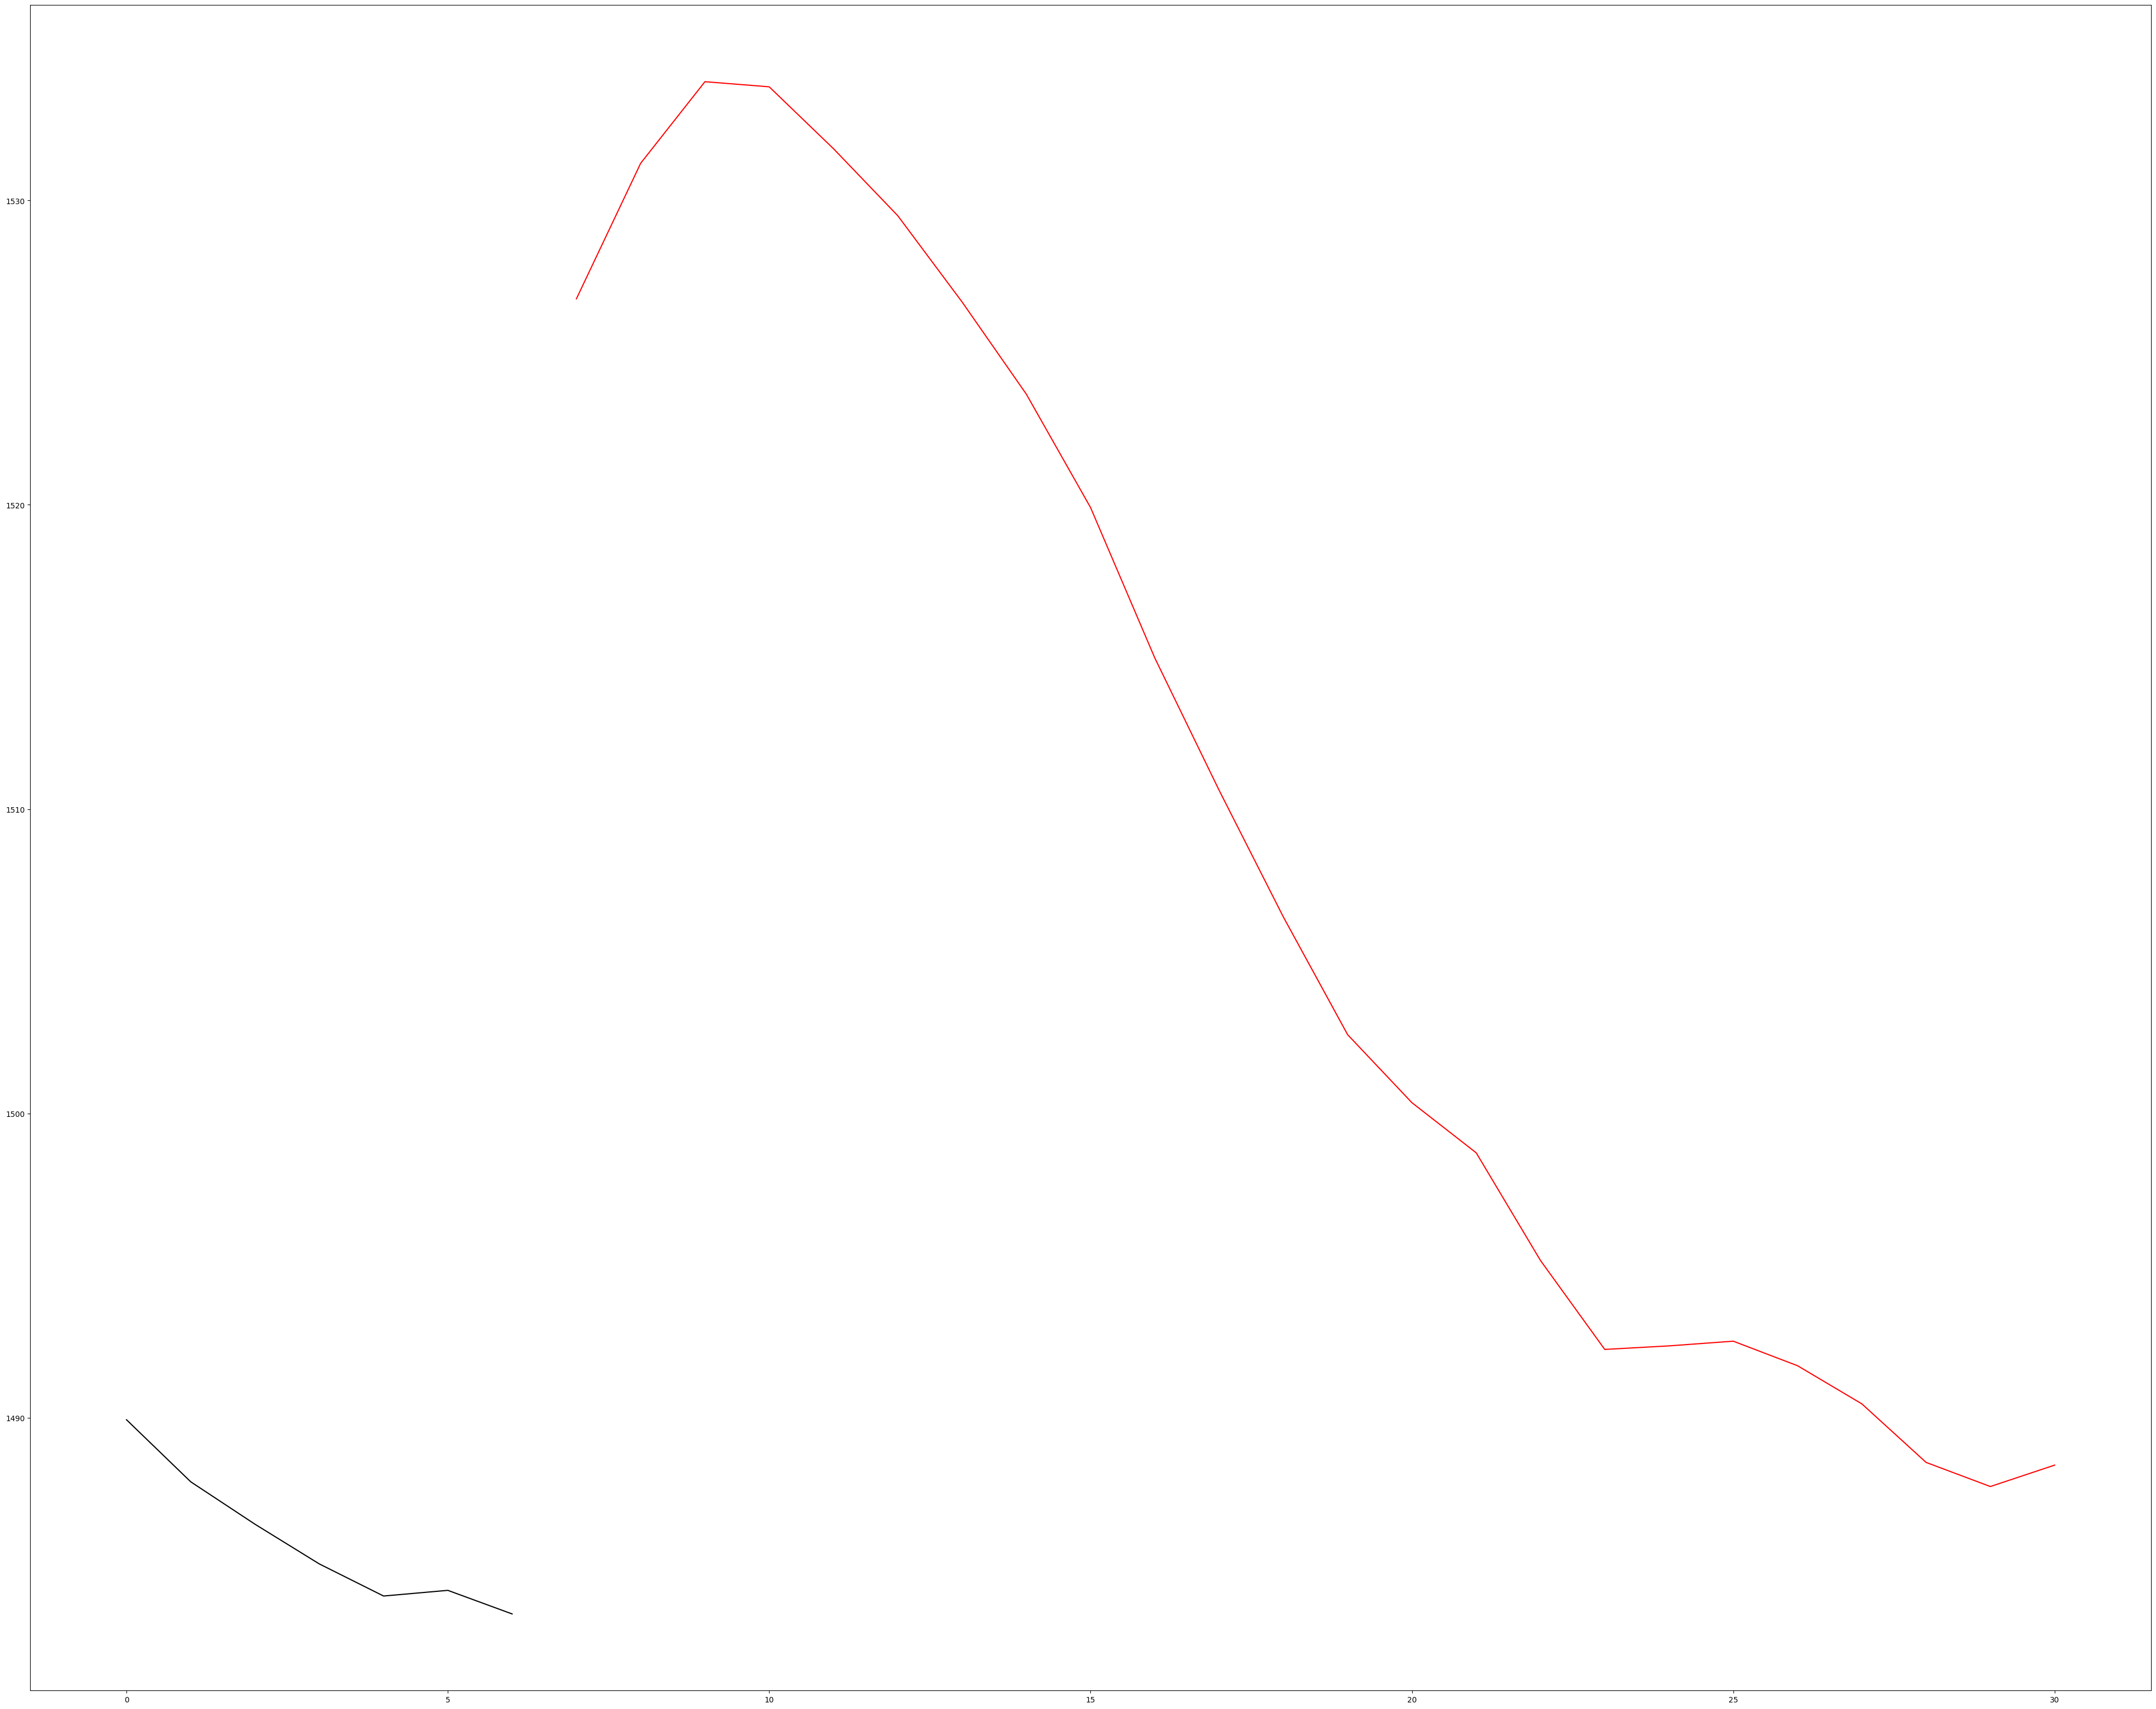

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trend_predictions[0], color='black')
plt.plot(data_backup['trend_close'].iloc[:24], color='red')

In [115]:
trend_predictions.shape, data_backup.shape

((4997, 7), (5019, 7))

In [116]:
type(trend_predictions)

numpy.ndarray

In [117]:
trend_predictions_df = pd.DataFrame(trend_predictions, index=data_backup.index[period+1:-output_step])

In [118]:
trend_predictions_df

,0,1,2,3,4,5,6
22,1489.933960,1487.893799,1486.499634,1485.195923,1484.141113,1484.327393,1483.552490
23,1488.006592,1486.032837,1484.837769,1483.799072,1482.939209,1483.162964,1482.699463
24,1486.764160,1484.878052,1483.870483,1483.126343,1482.417480,1482.693970,1482.493896
25,1485.577271,1483.790527,1482.939697,1482.439087,1481.841431,1482.170410,1482.151978
26,1484.923462,1483.286499,1482.613647,1482.322876,1481.869751,1482.246826,1482.388916
...,...,...,...,...,...,...,...
5014,15472.508789,15469.915039,15614.546875,15681.536133,15820.002930,15875.344727,15917.846680
5015,15480.986328,15477.897461,15622.601562,15689.268555,15827.979492,15883.041016,15925.810547
5016,15498.410156,15495.320312,15640.864258,15707.645508,15847.227539,15902.199219,15945.833984
5017,15525.891602,15523.242188,15670.274414,15737.656250,15878.583008,15933.675781,15978.666992


In [119]:
data_backup['trend_close'].iloc[15:-7]

22       1495.167494
23       1492.244276
24       1492.360705
25       1492.514993
26       1491.708566
            ...     
5014    16025.567139
5015    16065.452846
5016    16108.927455
5017    16158.243164
5018    16213.372489
Name: trend_close, Length: 4997, dtype: float64

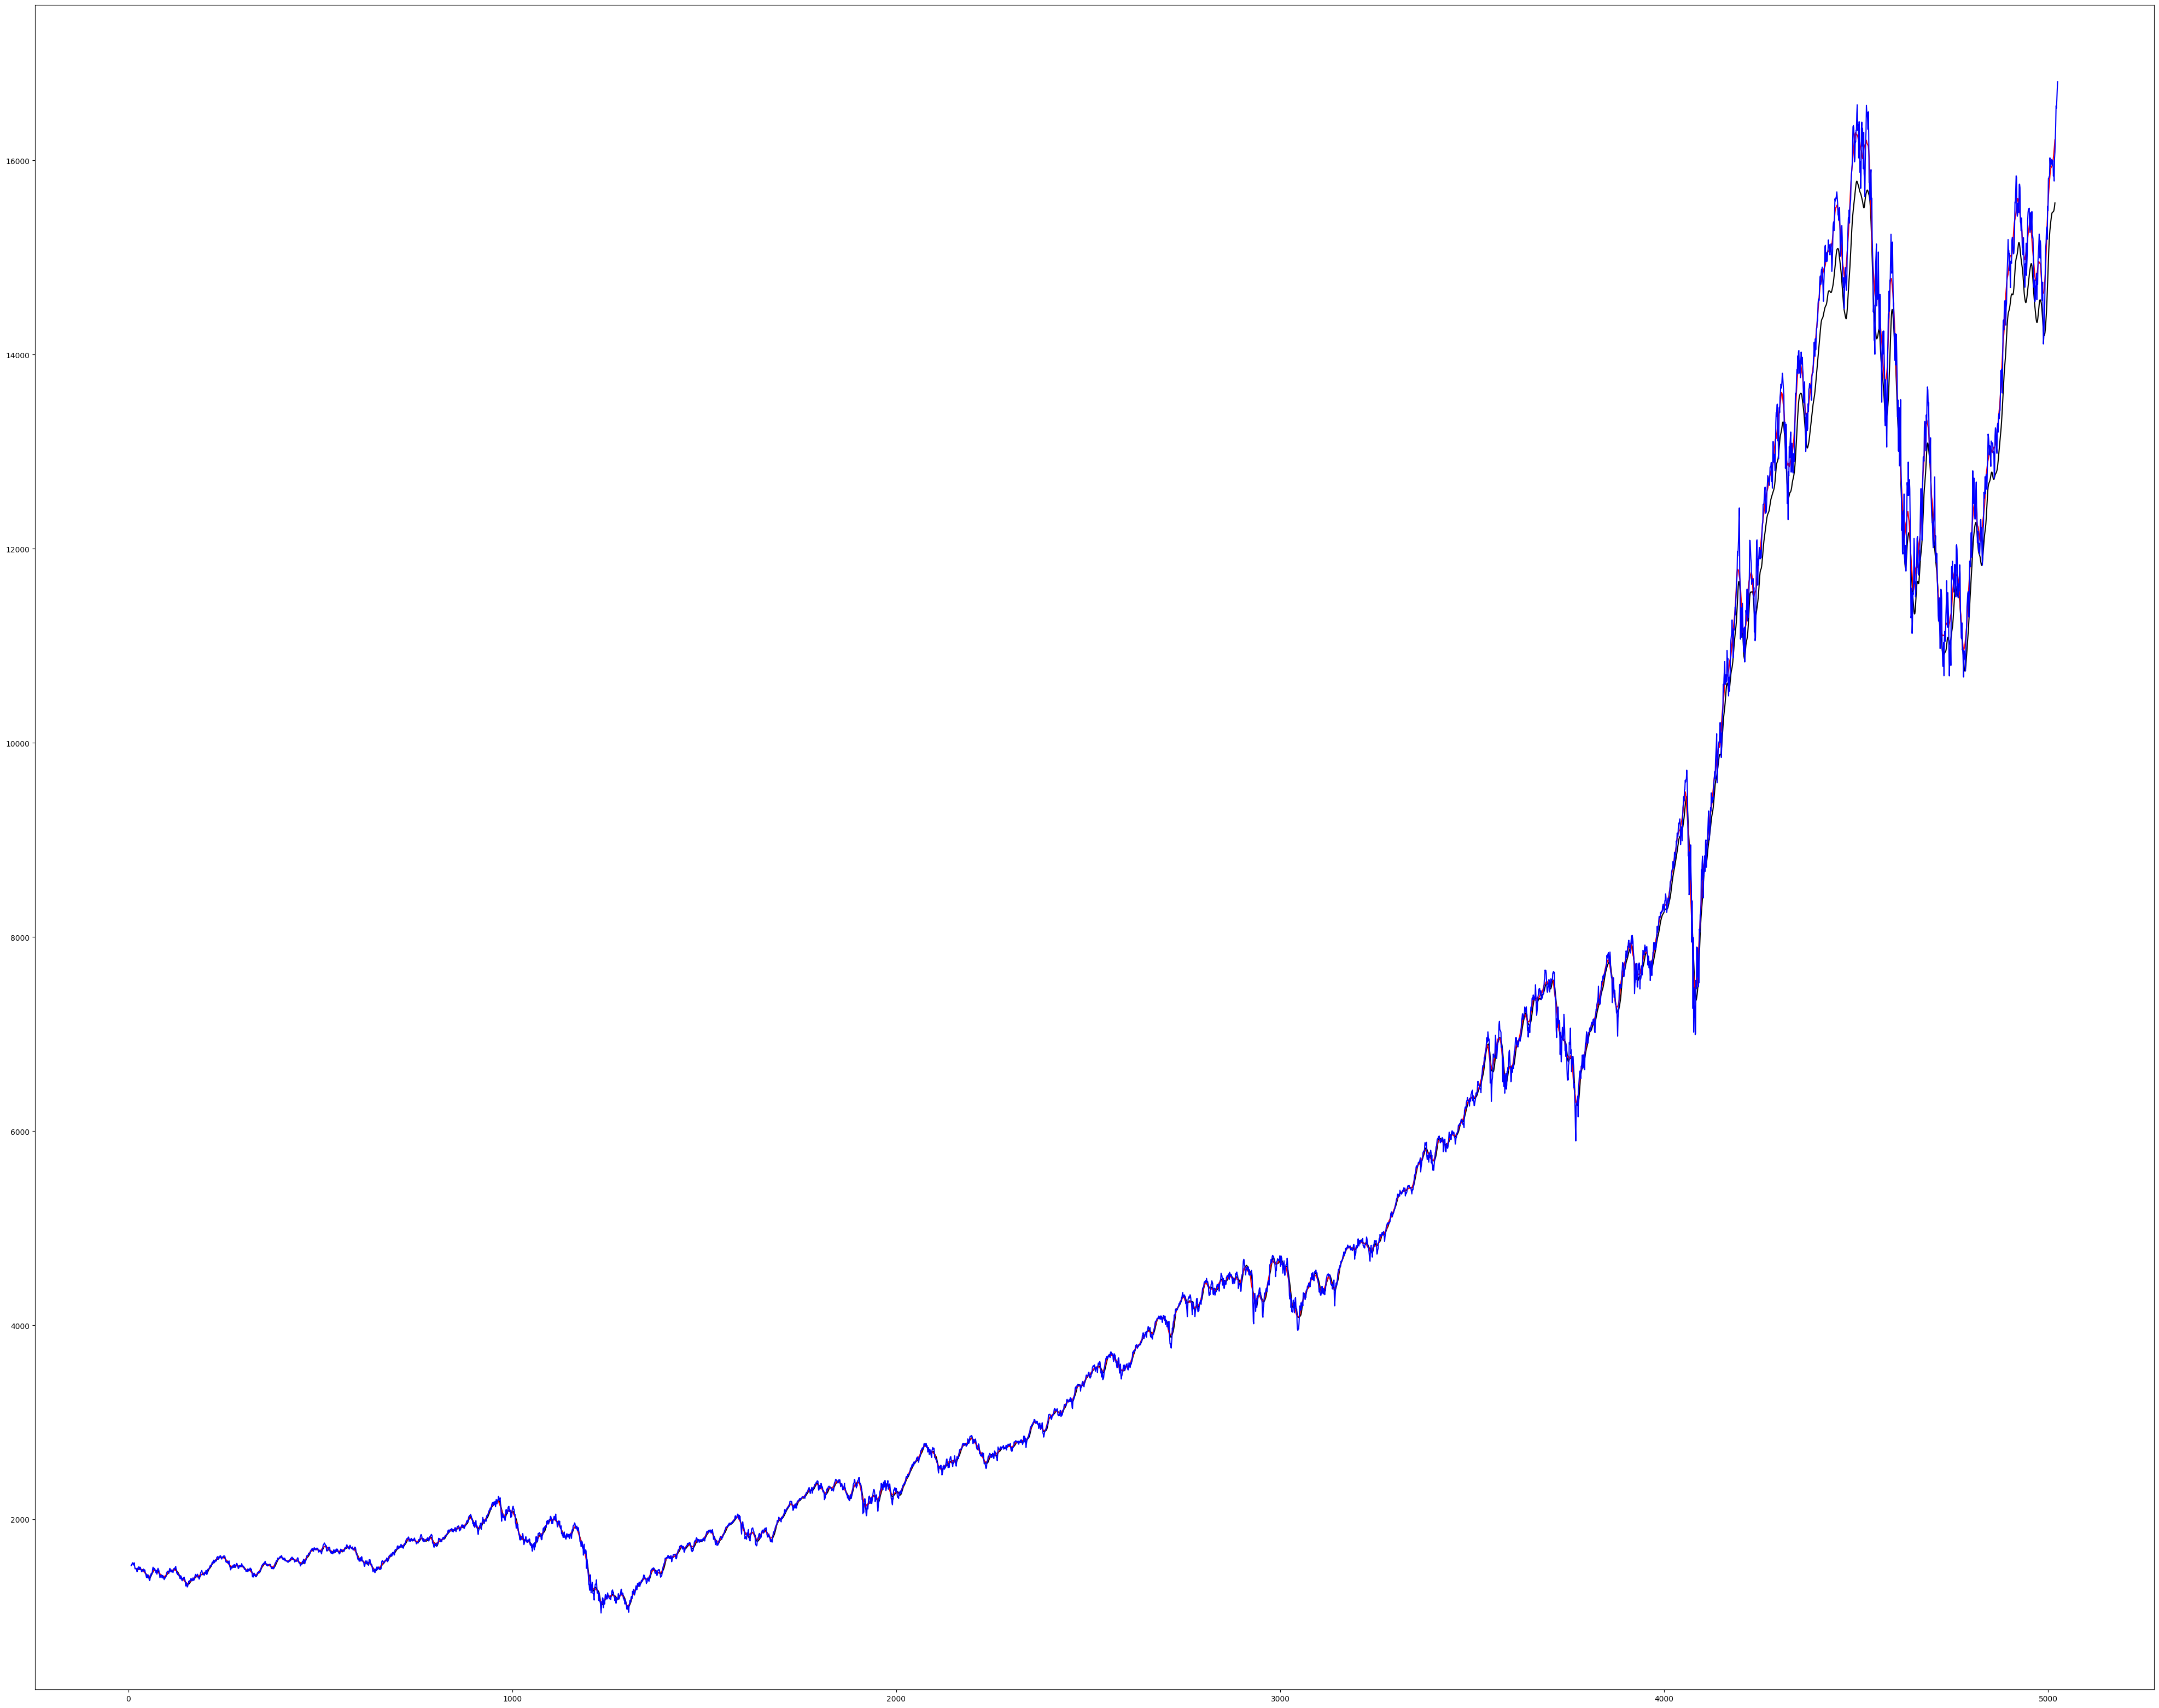

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trend_predictions_df[0], color='black')
plt.plot(data_backup['trend_close'].iloc[15:-7], color='red')
plt.plot(data_backup['close'], color='blue')

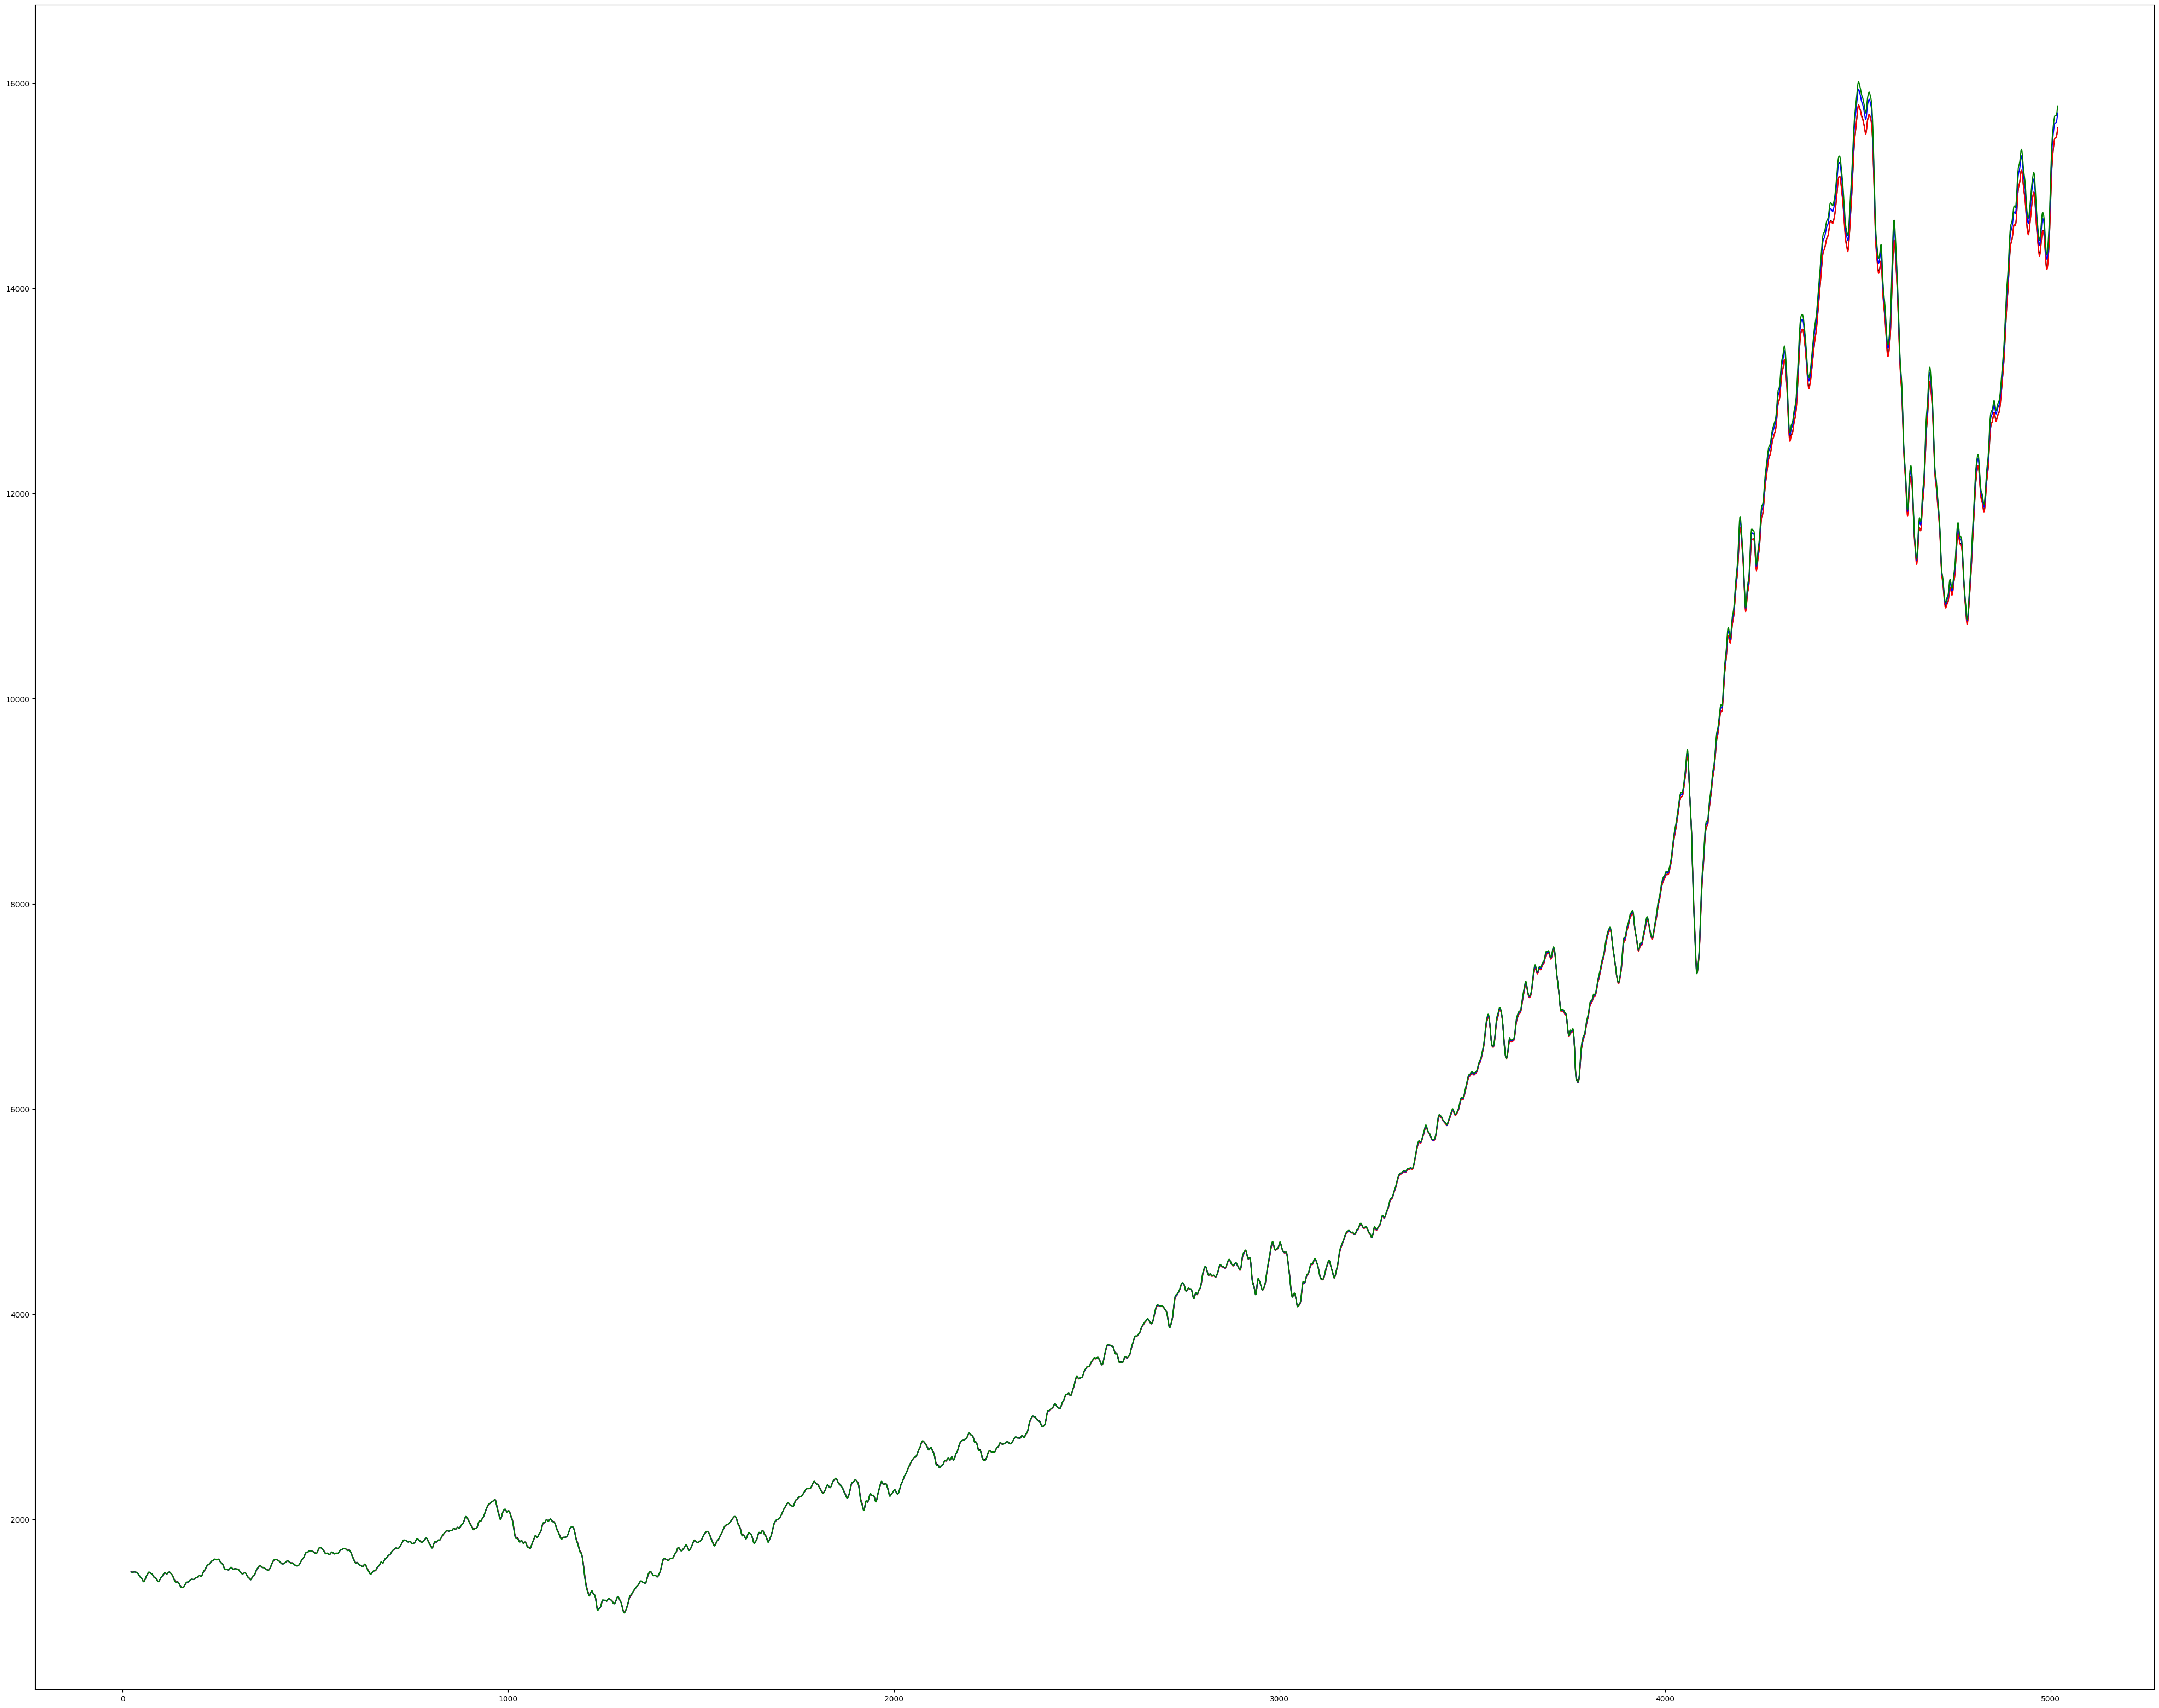

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trend_predictions_df[0], color='black')
plt.plot(trend_predictions_df[1], color='red')
plt.plot(trend_predictions_df[2], color='blue')
plt.plot(trend_predictions_df[3], color='green')

In [122]:
draft = trend_predictions_df.copy()

In [123]:
draft.index[-1]

5018

In [124]:
new_preds = pd.Series([
    draft[1].iloc[5017-21],
    draft[2].iloc[5017-21],
    draft[3].iloc[5017-21],
    draft[4].iloc[5017-21],
    draft[5].iloc[5017-21],
    draft[6].iloc[5017-21]
], index=range(draft.index[-1]+1, draft.index[-1]+7))

In [125]:
preds_total = pd.concat([draft[0], new_preds])

In [126]:
preds_total

22       1489.933960
23       1488.006592
24       1486.764160
25       1485.577271
26       1484.923462
            ...     
5020    15709.228516
5021    15777.587891
5022    15920.137695
5023    15975.550781
5024    16022.152344
Length: 5003, dtype: float32

In [127]:
data_backup['trend_close']

7        1526.767853
8        1531.222142
9        1533.902501
10       1533.733926
11       1531.700352
            ...     
5021    16373.880371
5022    16443.111851
5023    16518.808350
5024    16590.048758
5025    16647.806606
Name: trend_close, Length: 5019, dtype: float64

In [128]:
data_backup['close']

7        1524.780029
8        1534.079956
9        1532.010010
10       1553.619995
11       1552.869995
            ...     
5021    16562.369141
5022    16537.830078
5023    16623.449219
5024    16729.800781
5025    16811.849609
Name: close, Length: 5019, dtype: float64

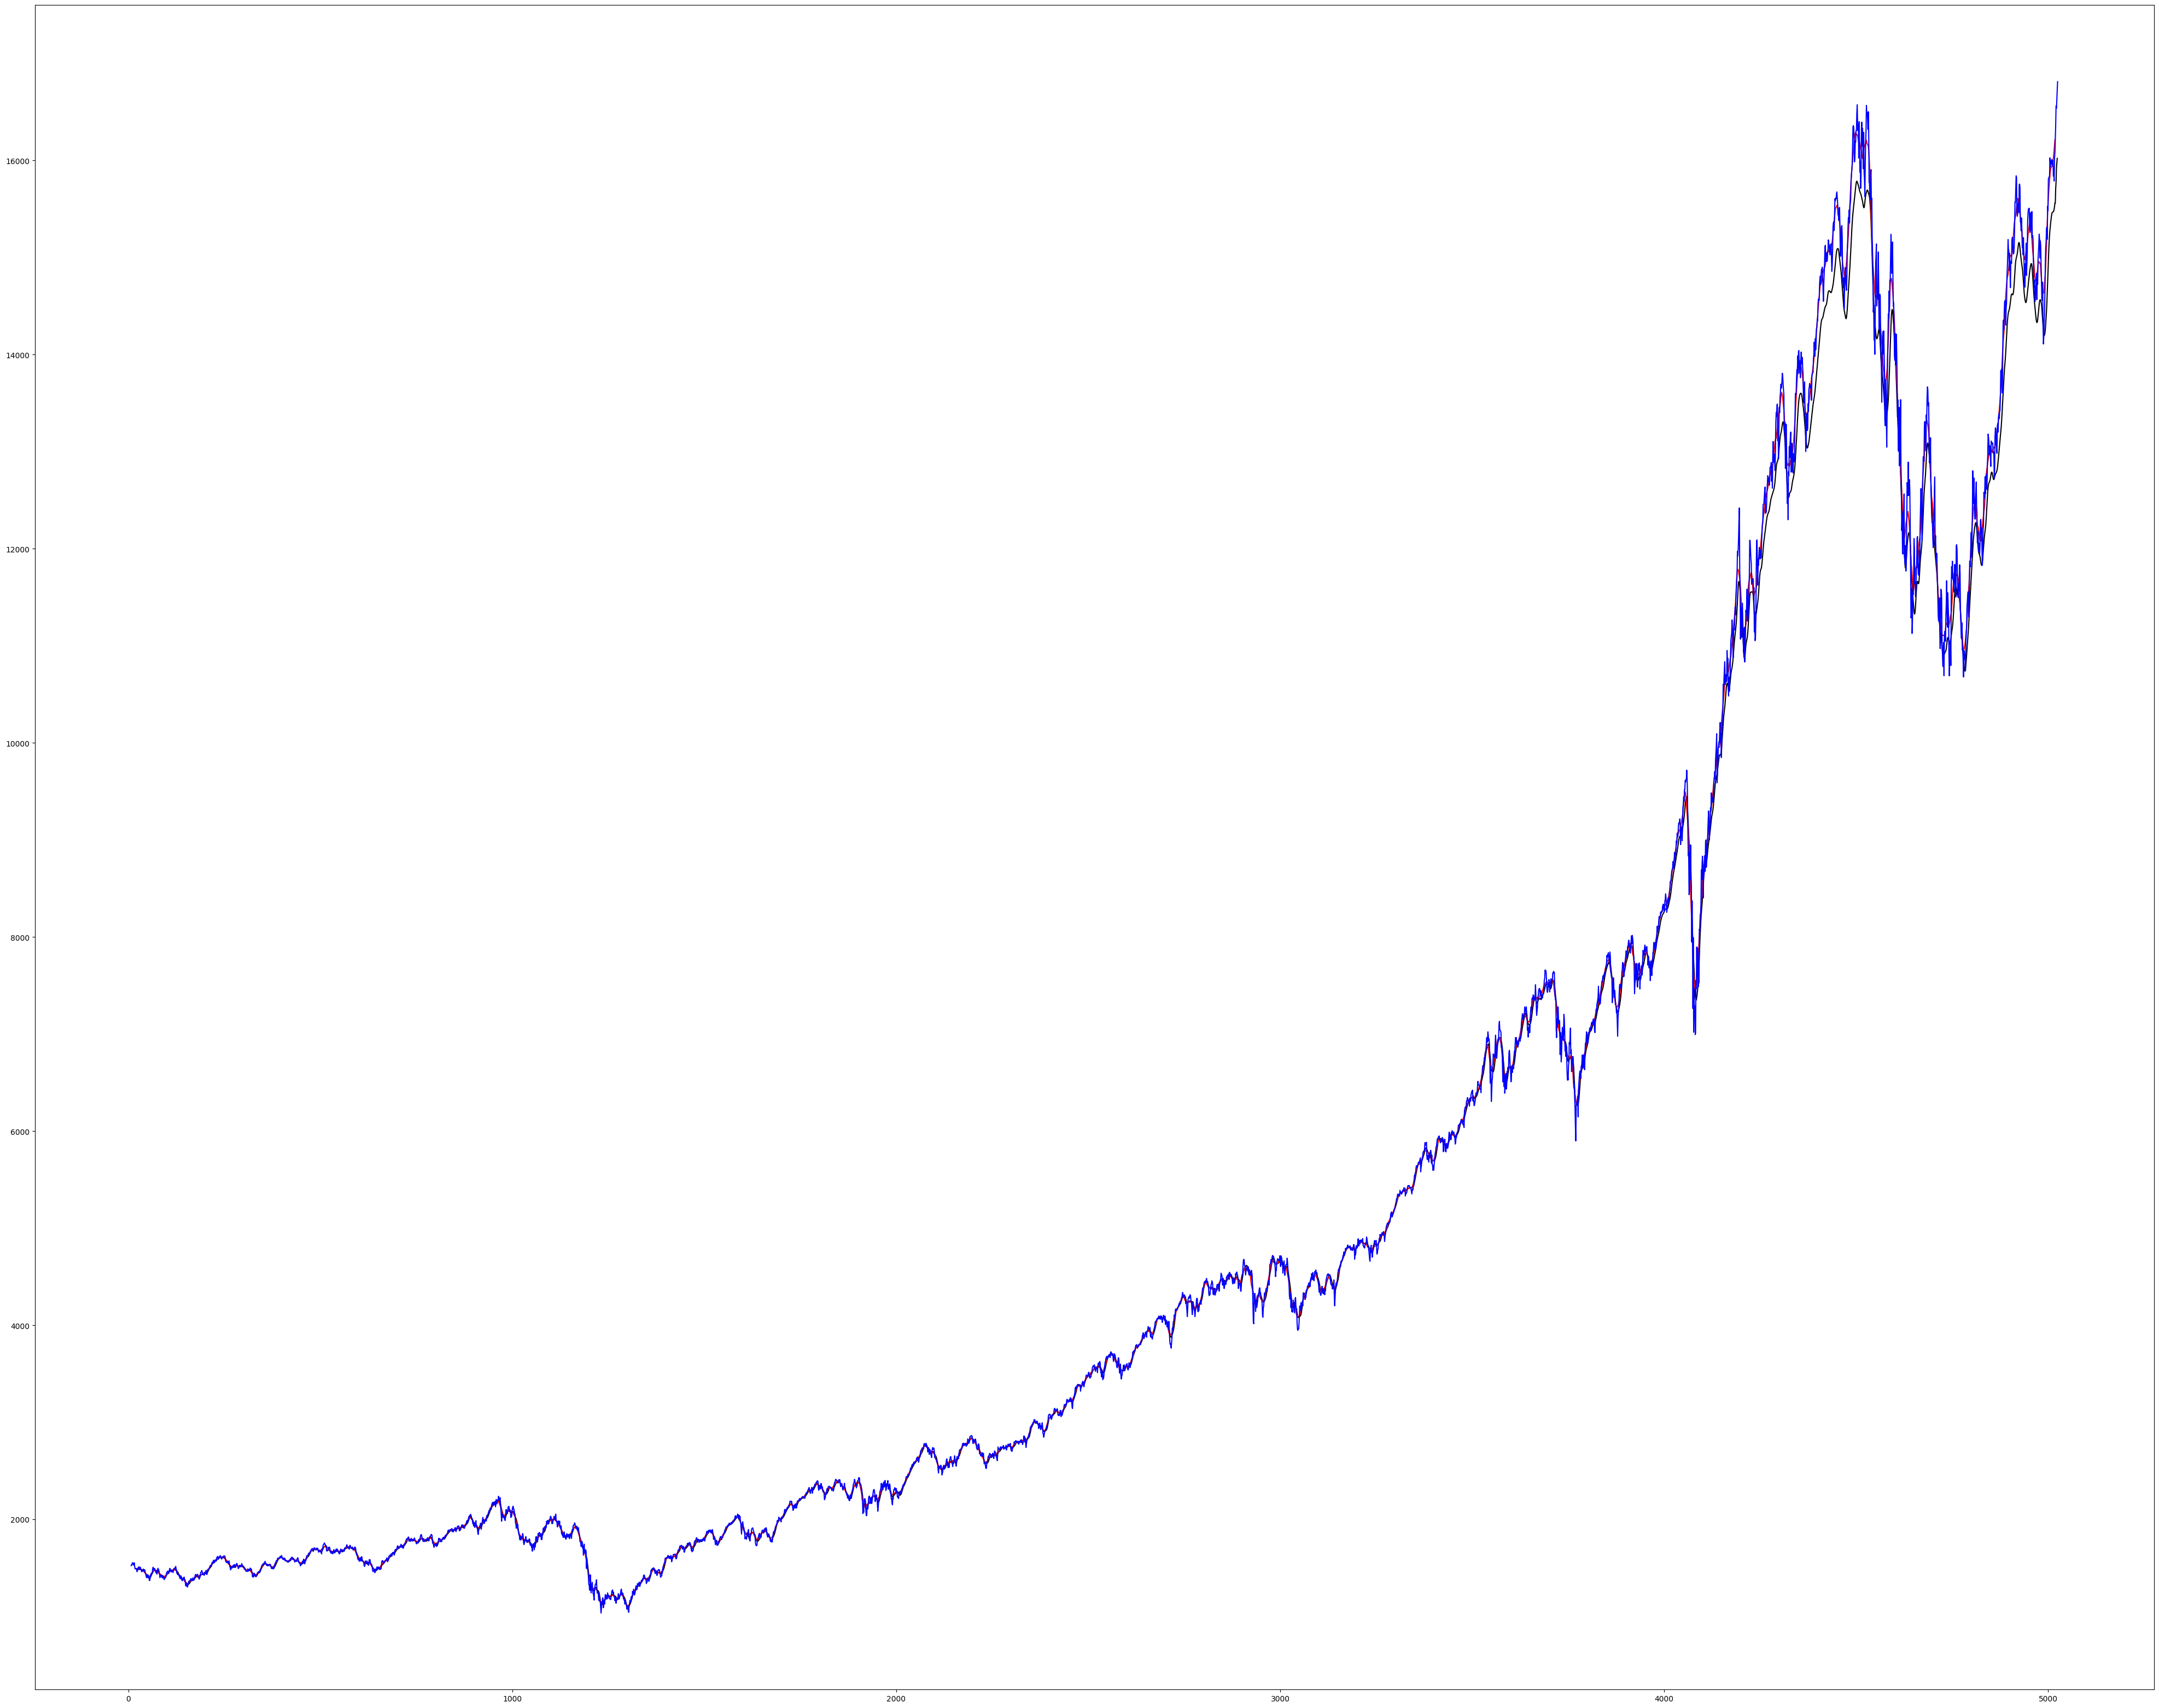

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(preds_total, color='black')
plt.plot(data_backup['trend_close'].iloc[15:-7], color='red')
plt.plot(data_backup['close'], color='blue')

In [130]:
data_backup['preds'] = preds_total

In [132]:
data_backup.to_excel(f'pred_trend_lstm_m5_4.xlsx')

In [131]:
data_backup

,date,open,high,low,close,volume,trend_close,preds
7,2004-01-13 00:00:00-05:00,1540.349976,1541.829956,1513.209961,1524.780029,2385700000,1526.767853,NaN
8,2004-01-14 00:00:00-05:00,1531.930054,1536.839966,1521.910034,1534.079956,2099970000,1531.222142,NaN
9,2004-01-15 00:00:00-05:00,1524.729980,1545.650024,1515.060059,1532.010010,2235590000,1533.902501,NaN
10,2004-01-16 00:00:00-05:00,1545.319946,1553.640015,1537.170044,1553.619995,2614390000,1533.733926,NaN
11,2004-01-20 00:00:00-05:00,1558.890015,1559.469971,1541.339966,1552.869995,2574190000,1531.700352,NaN
...,...,...,...,...,...,...,...,...
5021,2023-12-13 00:00:00-05:00,16392.179688,16581.039062,16357.209961,16562.369141,6732040000,16373.880371,15777.587891
5022,2023-12-14 00:00:00-05:00,16603.539062,16660.710938,16419.259766,16537.830078,8033170000,16443.111851,15920.137695
5023,2023-12-15 00:00:00-05:00,16587.000000,16669.769531,16557.009766,16623.449219,8377630000,16518.808350,15975.550781
5024,2023-12-18 00:00:00-05:00,16631.109375,16764.320312,16629.289062,16729.800781,5866080000,16590.048758,16022.152344


## adding signal noise to the trend prediction:

In [132]:
#data_backup.reset_index(inplace=True)

In [134]:
noise_high, _ = create_dataset(data_backup[['high']].to_numpy(), time_step=period, output_step=output_step)
noise_low, _ = create_dataset(data_backup[['low']].to_numpy(), time_step=period, output_step=output_step)

In [204]:
noise_high, noise_high.shape

(array([[ 1541.82995605,  1536.83996582,  1545.65002441, ...,
          1500.80004883,  1505.11999512,  1507.58996582],
        [ 1536.83996582,  1545.65002441,  1553.64001465, ...,
          1505.11999512,  1507.58996582,  1497.06994629],
        [ 1545.65002441,  1553.64001465,  1559.4699707 , ...,
          1507.58996582,  1497.06994629,  1482.34997559],
        ...,
        [15850.33984375, 15904.62988281, 15842.62988281, ...,
         16013.48046875, 16013.75      , 15852.45019531],
        [15904.62988281, 15842.62988281, 15876.87011719, ...,
         16013.75      , 15852.45019531, 15931.83984375],
        [15842.62988281, 15876.87011719, 16056.75976562, ...,
         15852.45019531, 15931.83984375, 15990.94042969]]),
 (4997, 14))

In [144]:
std_dev_high = np.array([np.std(val) for val in noise_high])
std_dev_low = np.array([np.std(val) for val in noise_low])

In [203]:
std_dev_high, std_dev_high.shape

(array([19.57527098, 22.30355039, 26.18519217, ..., 99.41436061,
        93.75491252, 90.87015255]),
 (4997,))

In [151]:
std_dev_noise = np.array([np.maximum(val_high, val_low) for val_high, val_low in zip(std_dev_high, std_dev_low)])

In [162]:
std_dev_noise

array([20.62580878, 22.30355039, 26.18519217, ..., 99.41436061,
       93.75491252, 90.87015255])

In [161]:
std_dev_noise.shape, trend_predictions.shape

((4997,), (4997, 7))

In [168]:
induced_high = np.array([trend_predictions[i] + std_dev_noise[i] for i in range(std_dev_noise.shape[0])])
induced_low = np.array([trend_predictions[i] - std_dev_noise[i] for i in range(std_dev_noise.shape[0])])

observation = np.array([])

In [174]:
induced_high_df = pd.DataFrame(induced_high, index=data_backup.index[period+1:-output_step])
induced_low_df = pd.DataFrame(induced_low, index=data_backup.index[period+1:-output_step])

In [175]:
induced_high_df['max'] = induced_high_df.max(axis=1)
induced_low_df['min'] = induced_low_df.max(axis=1)

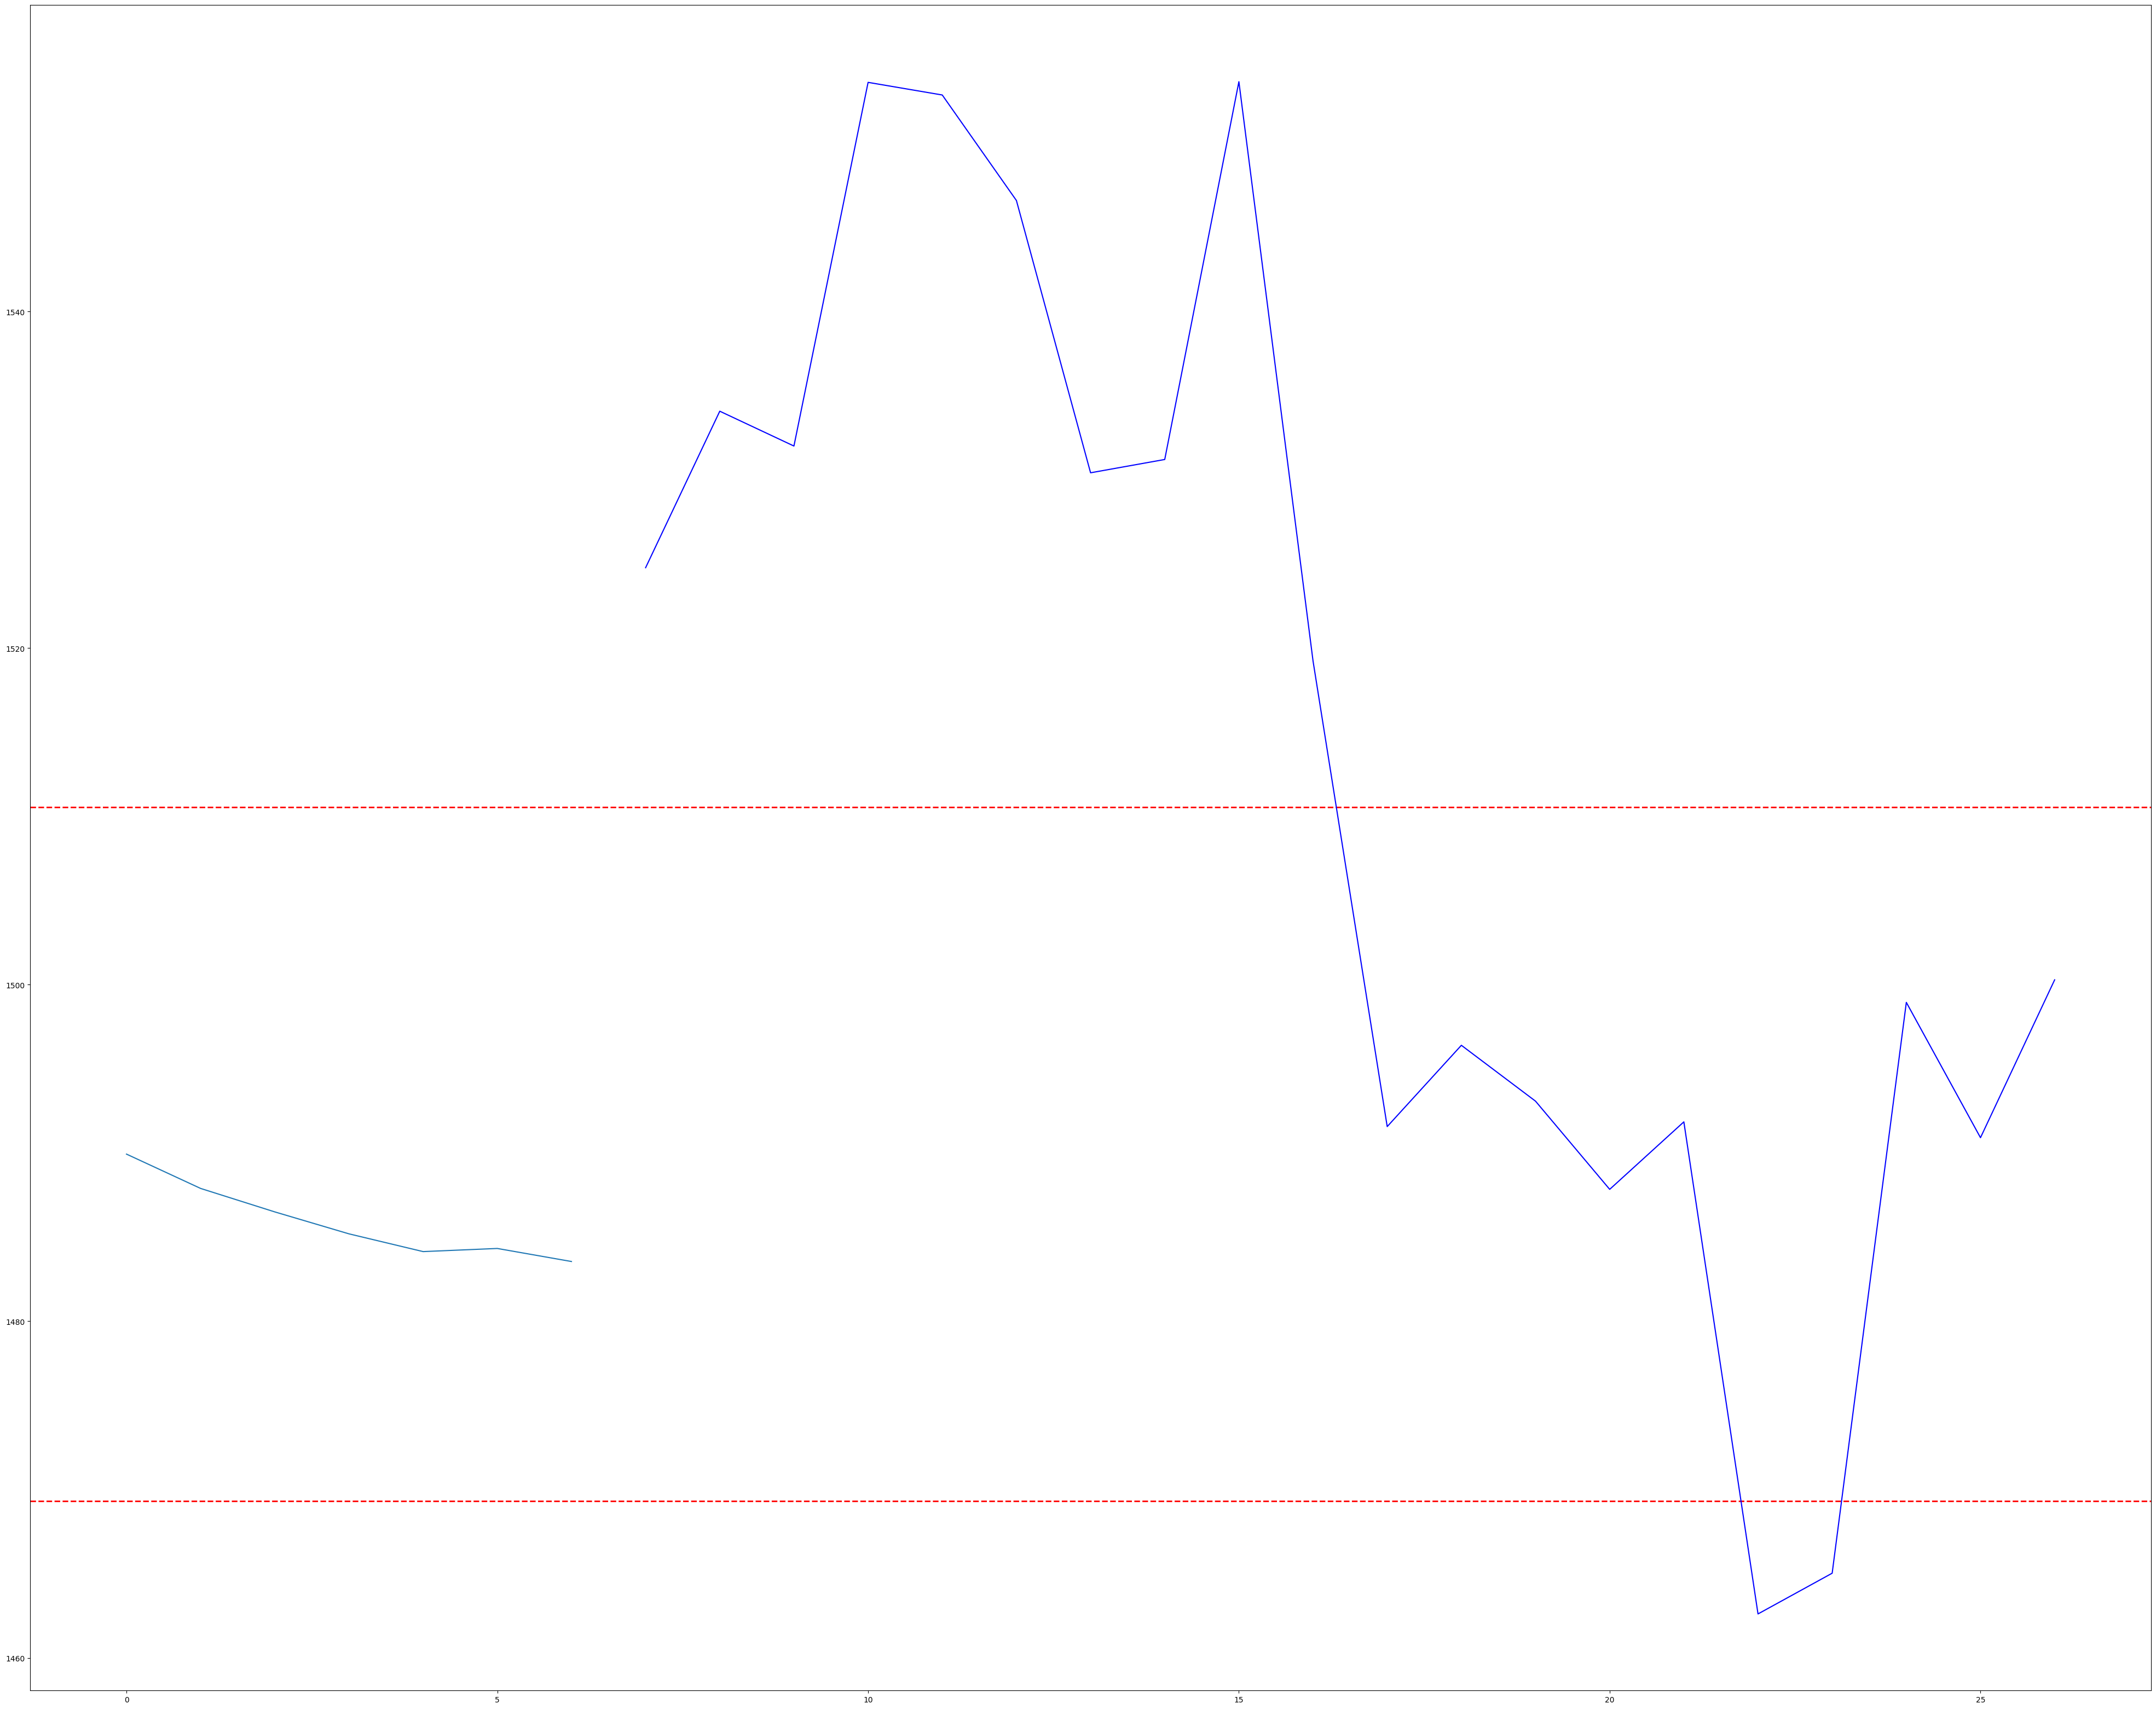

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trend_predictions[0])
plt.axhline(y=induced_high_df['max'].iloc[0], color='r', linestyle='--', linewidth=2)
plt.axhline(y=induced_low_df['min'].iloc[0], color='r', linestyle='--', linewidth=2)
plt.plot(data_backup['close'].iloc[:20], color='blue')

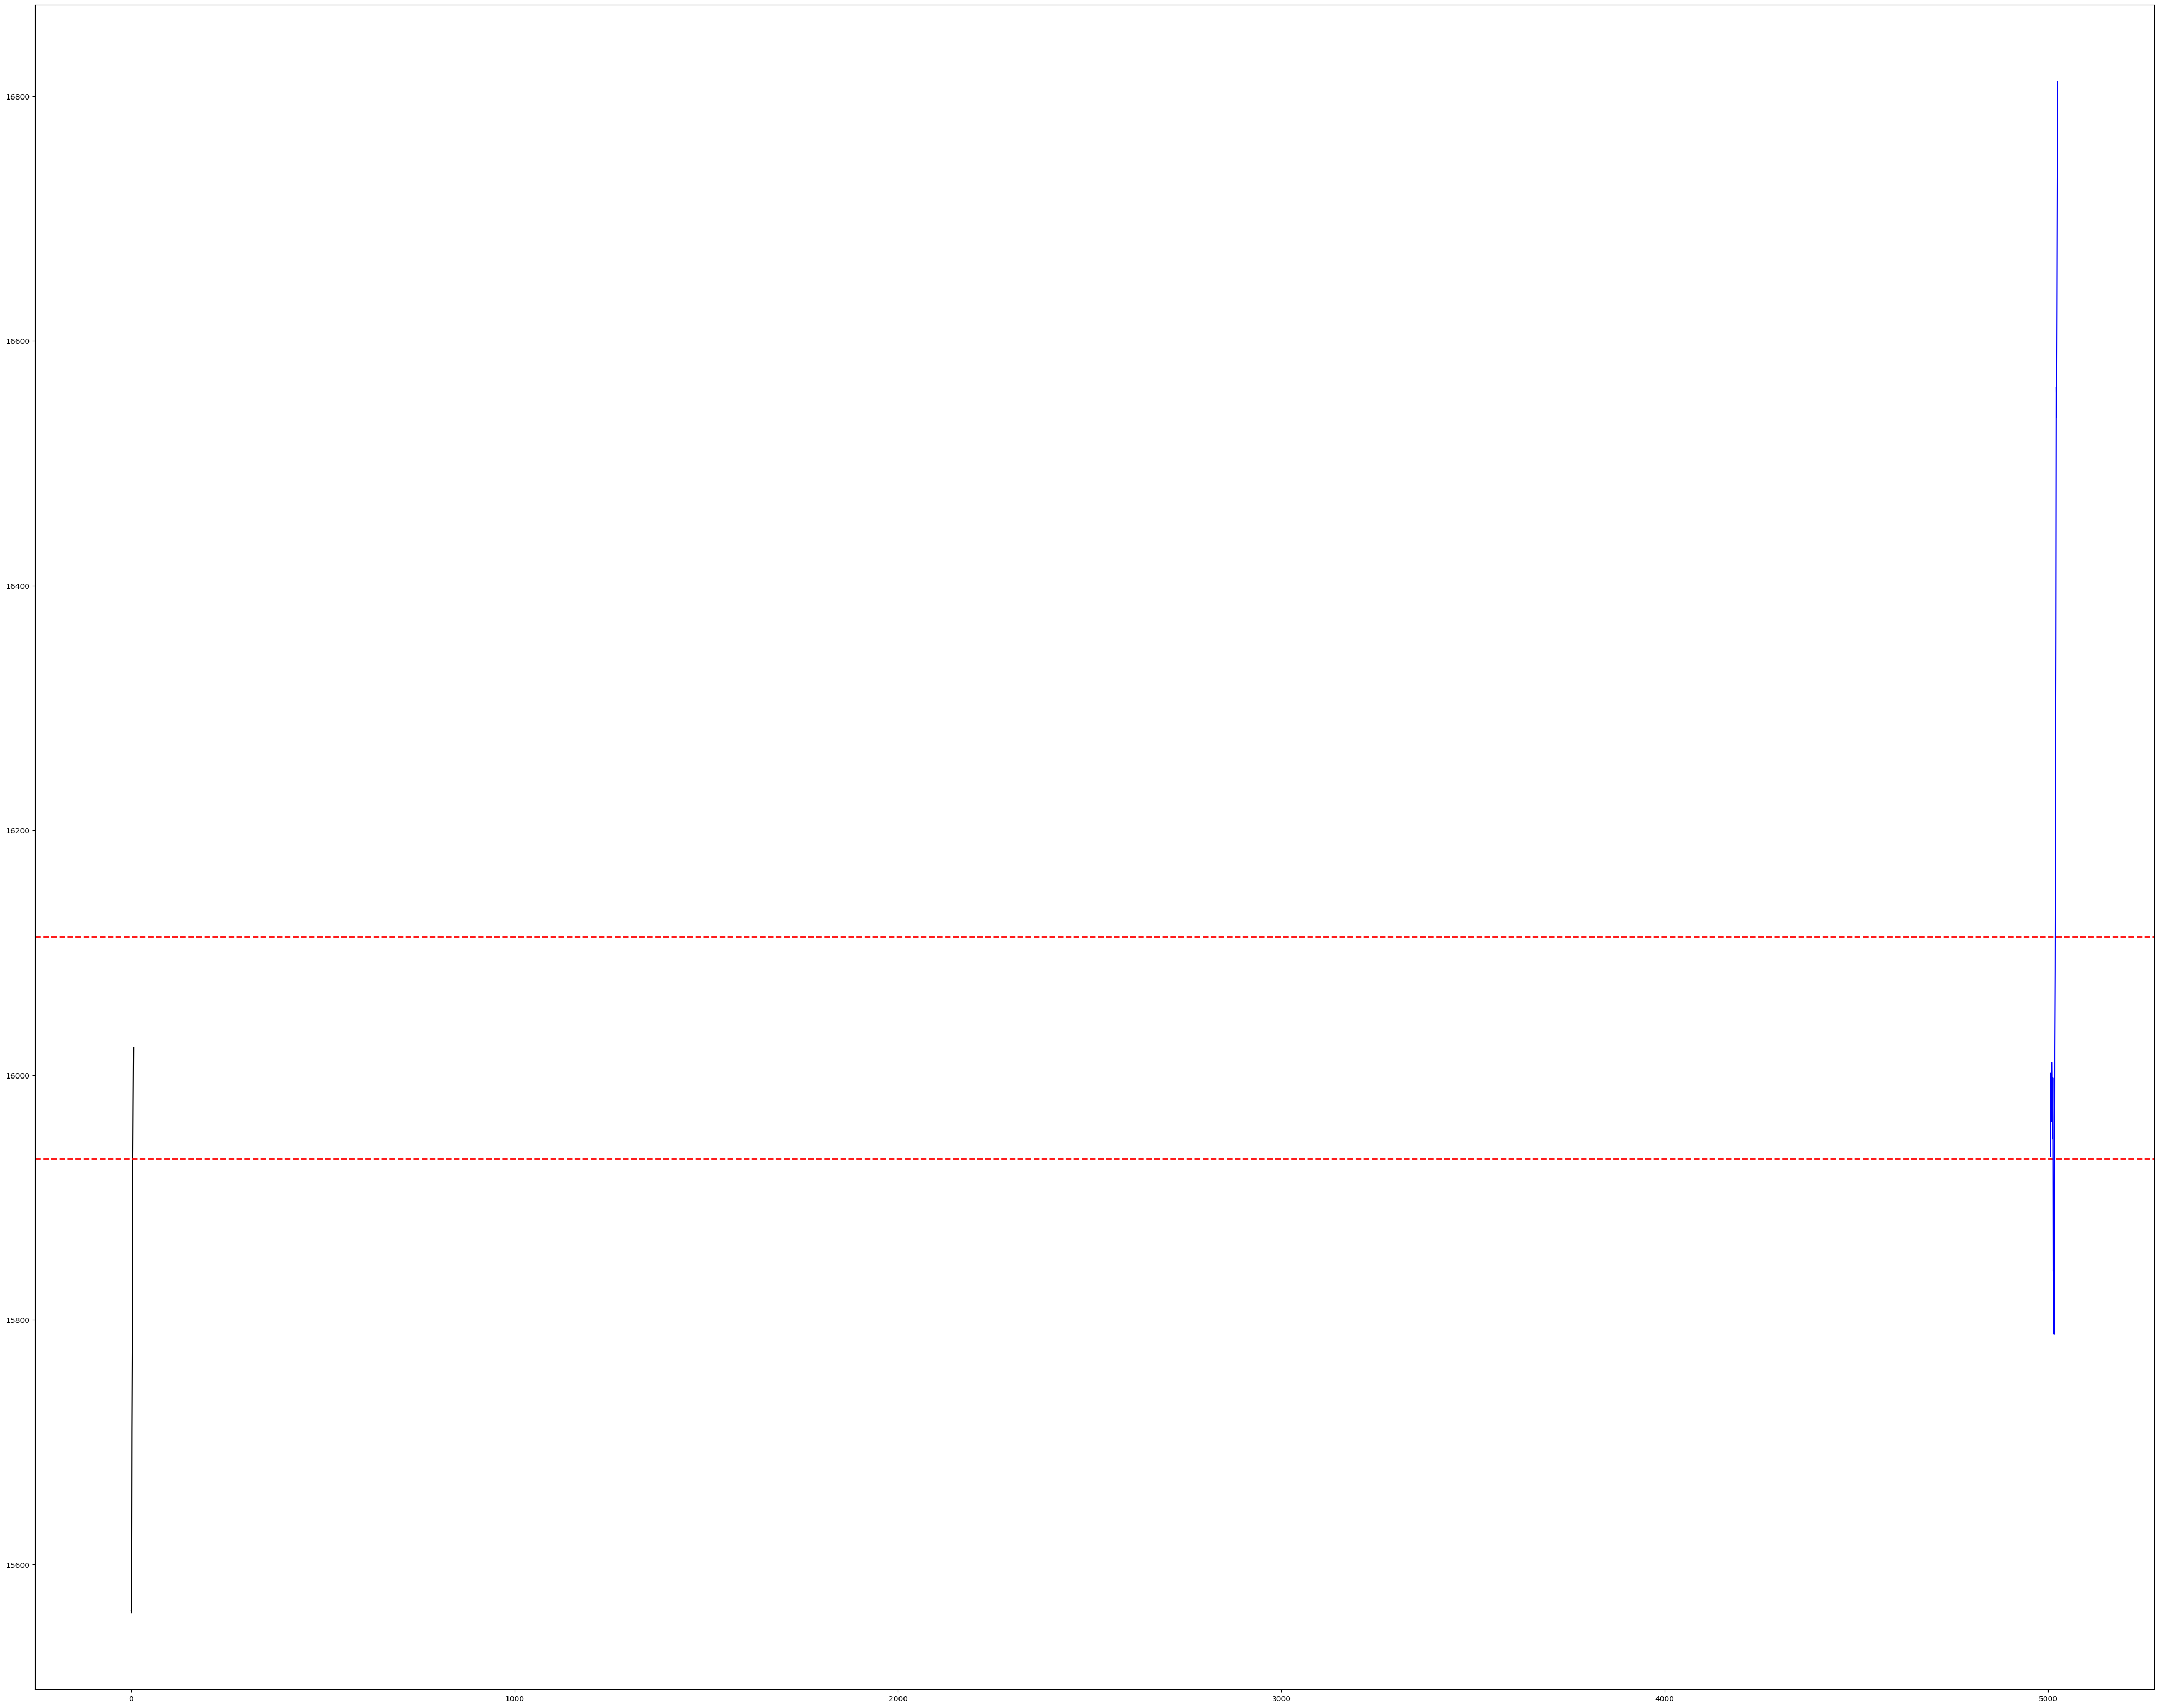

In [191]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(trend_predictions[-1], color='black')
plt.axhline(y=induced_high_df['max'].iloc[-1], color='r', linestyle='--', linewidth=2)
plt.axhline(y=induced_low_df['min'].iloc[-1], color='r', linestyle='--', linewidth=2)
plt.plot(data_backup['close'].iloc[-20:], color='blue')

In [197]:
draft_induced_high = induced_high_df['max'].copy()
draft_induced_low = induced_low_df['min'].copy()

In [194]:
data_backup['induced_high'] = induced_high_df['max']
data_backup['induced_low'] = induced_low_df['min']

In [198]:
data_backup.head(20)

,date,open,high,low,close,volume,trend_close,preds,induced_high,induced_low
7,2004-01-13 00:00:00-05:00,1540.349976,1541.829956,1513.209961,1524.780029,2385700000,1526.767853,NaN,NaN,NaN
8,2004-01-14 00:00:00-05:00,1531.930054,1536.839966,1521.910034,1534.079956,2099970000,1531.222142,NaN,NaN,NaN
9,2004-01-15 00:00:00-05:00,1524.729980,1545.650024,1515.060059,1532.010010,2235590000,1533.902501,NaN,NaN,NaN
10,2004-01-16 00:00:00-05:00,1545.319946,1553.640015,1537.170044,1553.619995,2614390000,1533.733926,NaN,NaN,NaN
11,2004-01-20 00:00:00-05:00,1558.890015,1559.469971,1541.339966,1552.869995,2574190000,1531.700352,NaN,NaN,NaN
12,2004-01-21 00:00:00-05:00,1545.530029,1554.890015,1529.400024,1546.599976,2421860000,1529.499281,NaN,NaN,NaN
13,2004-01-22 00:00:00-05:00,1550.979980,1556.060059,1530.420044,1530.420044,2353370000,1526.666779,NaN,NaN,NaN
14,2004-01-23 00:00:00-05:00,1535.410034,1546.689941,1519.739990,1531.209961,2253910000,1523.636060,NaN,NaN,NaN
15,2004-01-26 00:00:00-05:00,1526.569946,1553.660034,1522.949951,1553.660034,1946050000,1519.907488,NaN,NaN,NaN
16,2004-01-27 00:00:00-05:00,1548.640015,1552.540039,1519.199951,1519.229980,2151260000,1514.962847,NaN,NaN,NaN


In [196]:
data_backup.tail(20)

,date,open,high,low,close,volume,trend_close,preds,induced_high,induced_low
5006,2023-11-21 00:00:00-05:00,15951.549805,15968.089844,15866.820312,15933.620117,4128600000,15885.636335,15324.367188,16264.386719,15338.054688
5007,2023-11-22 00:00:00-05:00,16025.740234,16119.309570,15964.040039,16001.389648,3855240000,15915.112758,15361.958008,16242.506836,15427.553711
5008,2023-11-24 00:00:00-05:00,15974.849609,16007.429688,15940.620117,15982.009766,2541840000,15930.188477,15396.980469,16220.388672,15514.224609
5009,2023-11-27 00:00:00-05:00,15969.719727,16045.299805,15932.190430,15961.980469,4205880000,15931.478132,15427.962891,16231.410156,15560.169922
5010,2023-11-28 00:00:00-05:00,15940.290039,16031.519531,15921.070312,16010.429688,4474400000,15937.199219,15451.454102,16235.768555,15595.993164
5011,2023-11-29 00:00:00-05:00,16111.360352,16166.509766,15976.690430,15987.599609,4890220000,15952.771380,15463.937500,16224.208984,15622.033203
5012,2023-11-30 00:00:00-05:00,15987.660156,16013.480469,15825.669922,15947.870117,5678070000,15968.534633,15467.677734,16200.385742,15641.268555
5013,2023-12-01 00:00:00-05:00,15892.589844,16013.750000,15834.929688,15997.580078,5607000000,15990.509661,15469.128906,16175.519531,15659.294922
5014,2023-12-04 00:00:00-05:00,15837.120117,15852.450195,15695.580078,15839.669922,6270020000,16025.567139,15472.508789,16124.137695,15711.555664
5015,2023-12-05 00:00:00-05:00,15763.650391,15931.839844,15760.589844,15877.709961,6179120000,16065.452846,15480.986328,16077.730469,15773.890625


In [199]:
data_backup.to_excel(f'pred_trend_lstm_m5_4.xlsx')

In [200]:
# ADDENDUM
preds_total

22       1489.933960
23       1488.006592
24       1486.764160
25       1485.577271
26       1484.923462
            ...     
5020    15709.228516
5021    15777.587891
5022    15920.137695
5023    15975.550781
5024    16022.152344
Length: 5003, dtype: float32

#### test part: using whole data -not sequentially:

In [50]:
detrend_close = seasonal_close + resid_close
detrend_high = seasonal_high + resid_high
detrend_low = seasonal_low + resid_low

In [48]:
std_dev_detrend_high = detrend_high.std()
std_dev_detrend_low = detrend_low.std()

In [52]:
draft_noise = list()

for val in detrend_close:
    if val > std_dev_detrend_high:
        draft_noise.append(std_dev_detrend_high)
    elif val < -std_dev_detrend_low:
        draft_noise.append(-std_dev_detrend_low)
    else:
        draft_noise.append(val)

draft_noise = pd.Series(draft_noise)

In [53]:
observation = preds_total + draft_noise

In [61]:
observation

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
5020   NaN
5021   NaN
5022   NaN
5023   NaN
5024   NaN
Length: 5025, dtype: float64

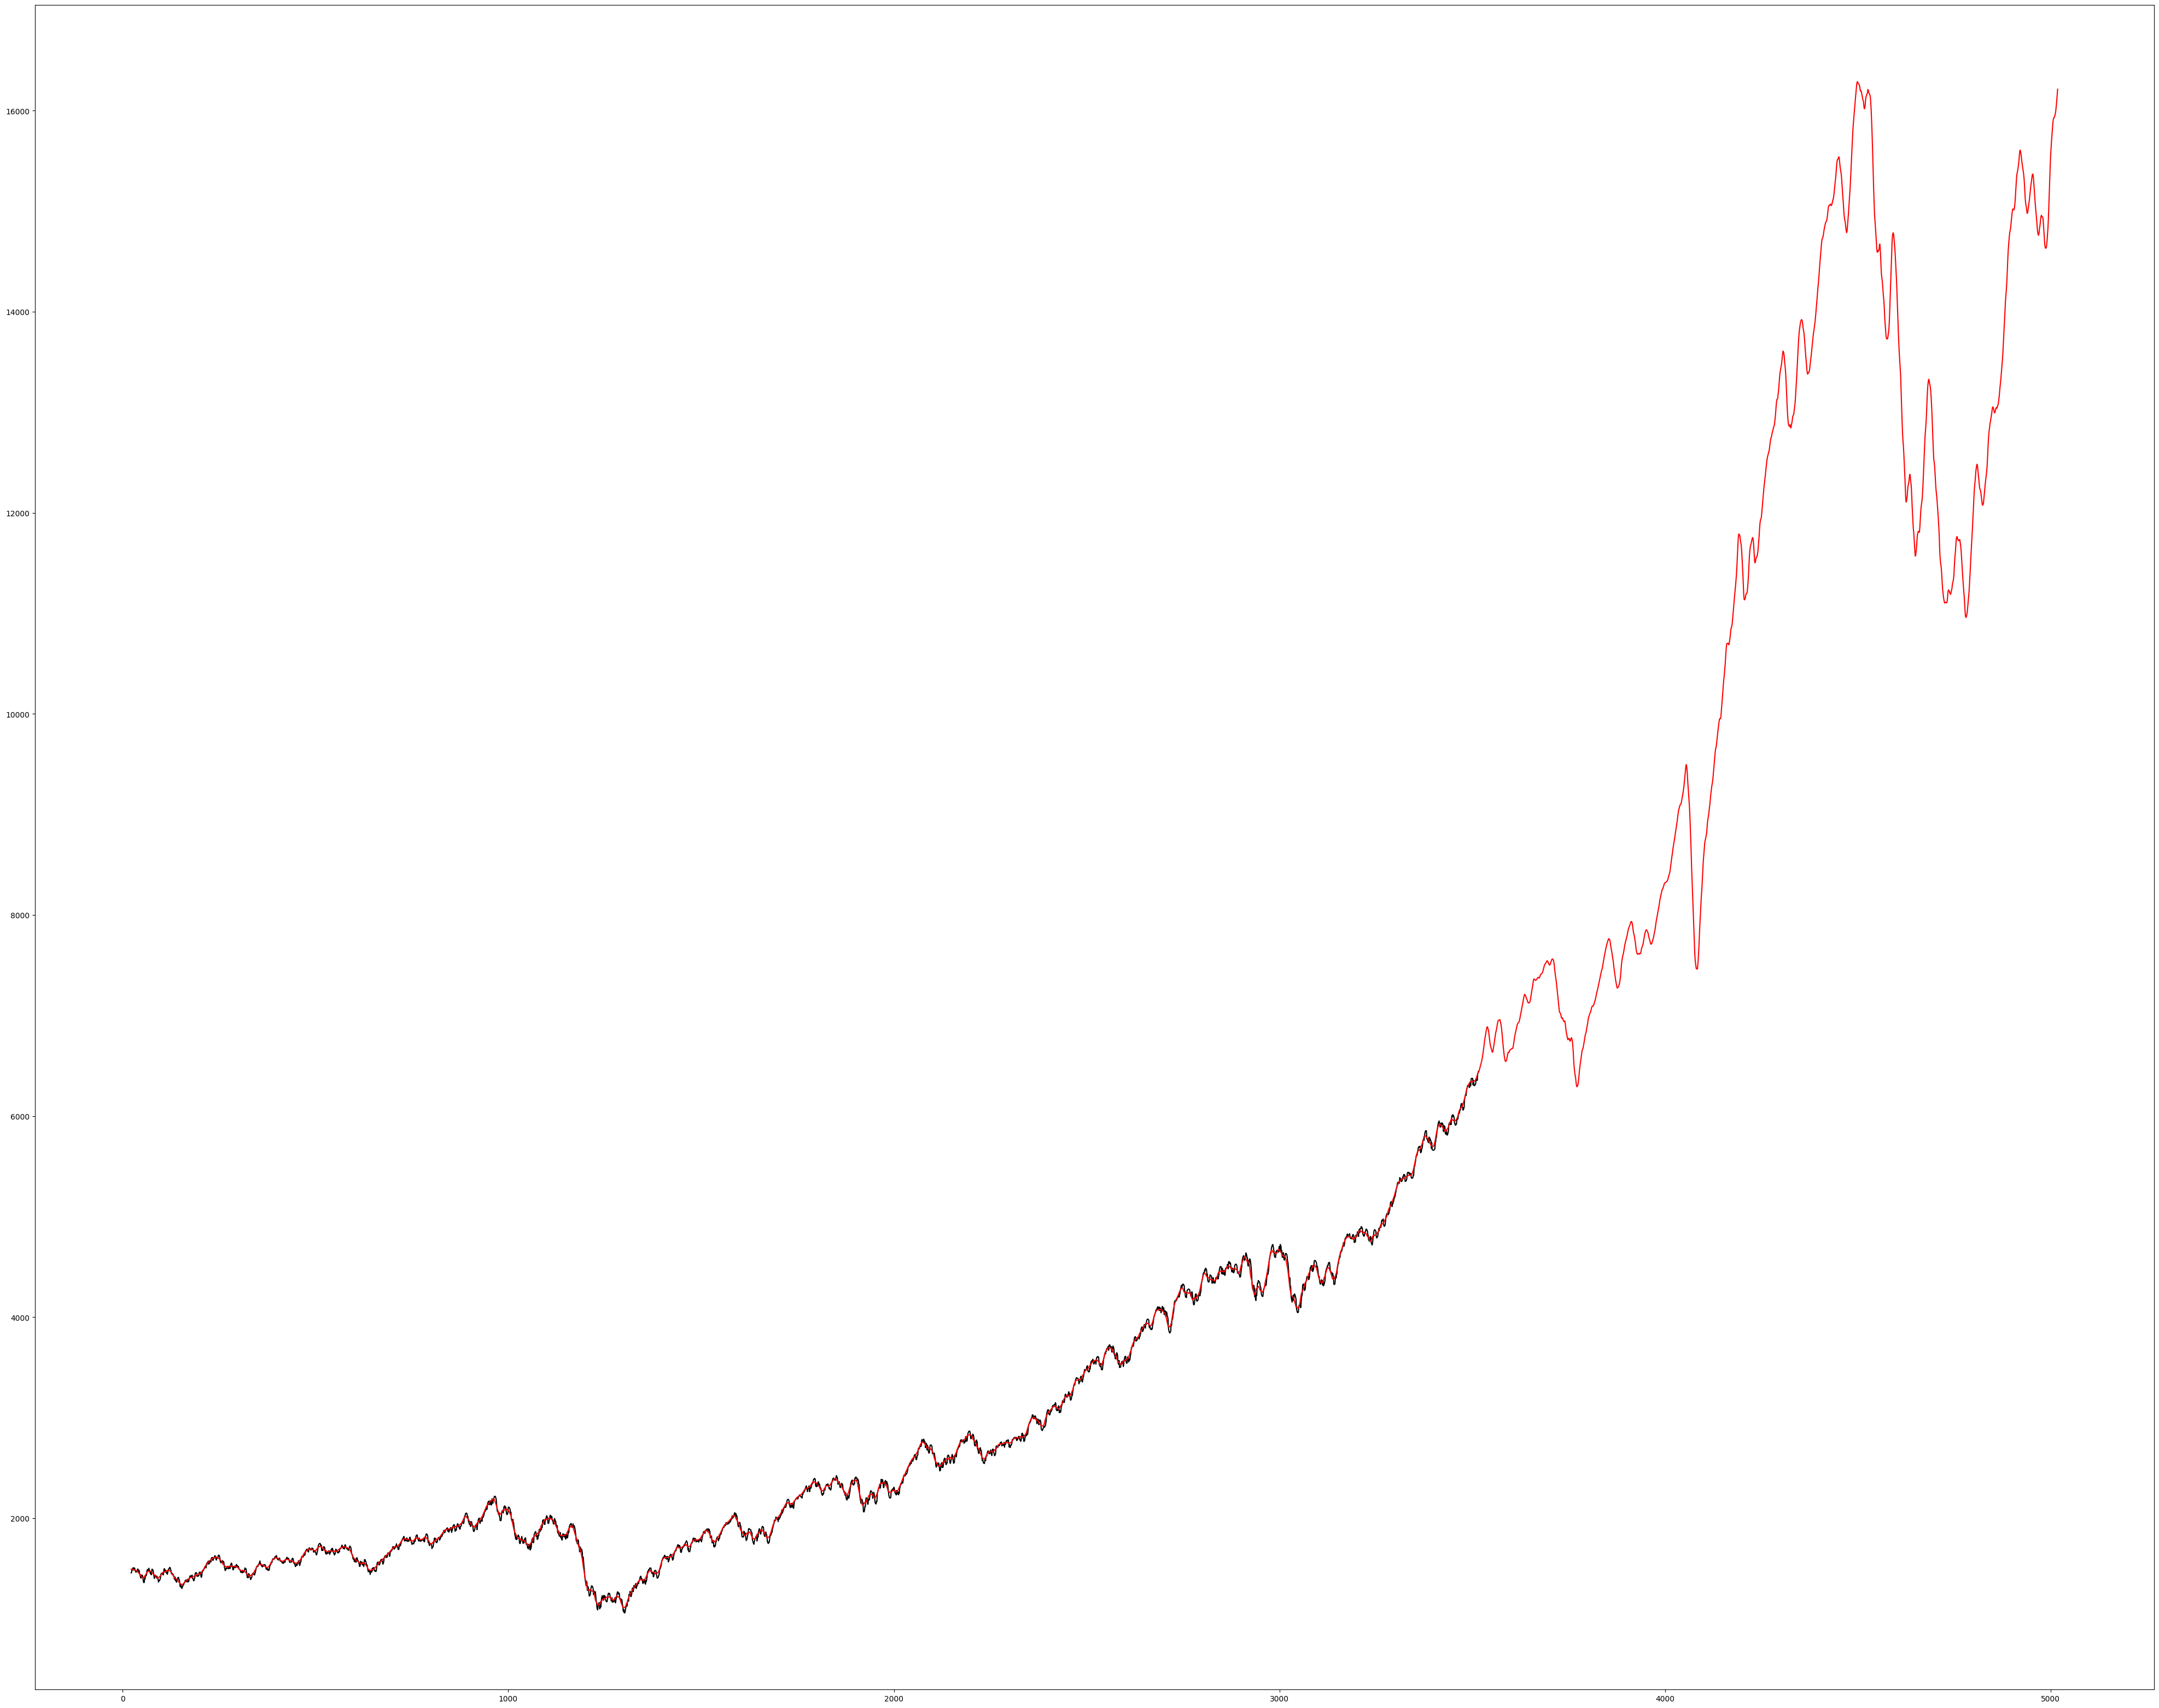

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(observation, color='black')
plt.plot(data_backup['trend_close'].iloc[15:-7], color='red')
#plt.plot(data_backup['close'].iloc[15:-7], color='green')